<a href="https://colab.research.google.com/github/ijoonc/Krauss-Lab-Tribology-Image-Processing-Simulator/blob/main/Tribology_Threshold_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the Particle Threshold Simulator for Krauss Lab Tribology 2023.
Source for the algorithm: https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Watershed_Algorithm_Marker_Based_Segmentation.php


In [ ]:
# First install OpenCV if not previously installed on computer
!pip3 install opencv-python

# Install ImageIO for image processing
!pip3 install imageio

# Download Rolling Ball for T=thresholding sequence
!pip install opencv-rolling-ball

# Download split-image just in case we need to split images
!pip install split-image

# PyBasics is a shading correction Python 
# !pip install pybasics

In [ ]:
# Gain access to the Krauss Tribology Lab Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Change working directory
%cd '/content/gdrive/Shareddrives/Krauss Tribology Research/Fall 2022 - Spring 2023/Pictures/9-26-2022'

In [ ]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
import skimage.color
import skimage.filters
import os

import cv2
from PIL import Image
import numpy as np
from cv2_rolling_ball import subtract_background_rolling_ball
from google.colab.patches import cv2_imshow

In [ ]:
# Check current list of items in the directory.
%ls

### The Thresholding Algorithm is shown in the cell below.

In [ ]:
# Obtain the folder path
dir_path = '2%'
count = 0

# Iterate directory to determine the number of images in the folder
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)



# Let us start off with the 2% Hitec concentration!
%cd '2%'

# Iterate through all the files and threshold each of them
for num in range(1, count + 1):

  # Obtain the rgb values of image to display later on
  img = cv2.imread(f'img{num}.jpg')
  b,g,r = cv2.split(img)
  rgb_img = cv2.merge([r,g,b])

  # Grayscale the image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Threshold the image
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # Portray the resulting image
  plt.subplot(121), plt.imshow(rgb_img)
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(122), plt.imshow(thresh, 'gray')
  plt.title("Otus's Binary Threshold"), plt.xticks([]), plt.yticks([])

  plt.show()               


  # Noise removal using morphologyEx() --> we can switch between opening and closing to see which one is better
  kernel = np.ones((2, 2), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
  closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)

  # Display the images again
  plt.subplot(131), plt.imshow(rgb_img)
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(132), plt.imshow(thresh, 'gray')
  plt.title("Otus's Binary Threshold"), plt.xticks([]), plt.yticks([])

  plt.subplot(133), plt.imshow(closing, 'gray')
  plt.title("morphologyEx"), plt.xticks([]), plt.yticks([])

  plt.show()


  # Dilate our image so that thresholding is much easier to visualize (for ourselves and the computer)
  # Dilate with respect to the background
  bg = cv2.dilate(opening, kernel, iterations = 3)

  # Show the images again
  plt.subplot(221), plt.imshow(rgb_img)
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(222), plt.imshow(thresh, 'gray')
  plt.title("Otus's Binary Threshold"), plt.xticks([]), plt.yticks([])

  plt.subplot(223), plt.imshow(closing, 'gray')
  plt.title("morphologyEx:Closing:2x2"), plt.xticks([]), plt.yticks([])

  plt.subplot(224), plt.imshow(bg, 'gray')
  plt.title("Dilation"), plt.xticks([]), plt.yticks([])

  plt.show()


  # Apply distance thresholding to increase accuracy for overall threshold
  dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)

  # Overall Threshold
  ret, fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

  # Display the images again
  plt.subplot(321), plt.imshow(rgb_img)
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(322), plt.imshow(thresh, 'gray')
  plt.title("Otsu's Binary Threshold"), plt.xticks([]), plt.yticks([])

  plt.subplot(323), plt.imshow(closing, 'gray')
  plt.title("morphologyEx:Closing:2x2"), plt.xticks([]), plt.yticks([])

  plt.subplot(324), plt.imshow(bg, 'gray')
  plt.title("Dilation"), plt.xticks([]), plt.yticks([])

  plt.subplot(325), plt.imshow(dist_transform, 'gray')
  plt.title("Distance Transform"), plt.xticks([]), plt.yticks([])

  plt.subplot(326), plt.imshow(fg, 'gray')
  plt.title("Thresholding"), plt.xticks([]), plt.yticks([])

  plt.tight_layout()

  # Save the current 6 images into Google Drive
  # plt.savefig('images.png',
  #             bbox_inches='tight',
  #             pad_inches=0,
  #             format='png',
  #             dpi=300)

  plt.show()


  # Remove the axes and white border
  plt.axis('off')
  fig = plt.imshow(fg, cmap="gray", interpolation='nearest')

  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)

  # Set directory to Thresholded Images folder
  %cd ..
  %cd .. 
  %cd 'Encoded Pictures/Thresholded Images'

  # Save the image
  plt.savefig(f'threshold_image{num}.png',
              bbox_inches='tight',
              pad_inches=0,
              format='png',
              dpi=300)

  plt.show()


  # Image Resizing to account for particles along the edges of the image
  image = Image.open(f'threshold_image{num}.png')
  print(f"Original size : {image.size}") # 1359x906

  img_resized = image.resize((1200, 800))

  # Set directory to the Resized Images folder
  %cd ..
  %cd 'Resized Images'

  img_resized.save(f'resized_image{num}.png')


  # Overlay the Shrunken Image on the Black Background
  # Opening the primary image (used in background)
  %cd ..
  img1 = Image.open("black-background.jpg")
    
  # Opening the secondary image (overlay image)
  %cd 'Resized Images'
  img2 = Image.open(f"resized_image{num}.png")

  # Pasting img2 image on top of img1 starting at coordinates (0, 0)
  img1.paste(img2, (80, 50), mask = img2)
    
  # Displaying the image
  img1.show()

  # Set directory to the Resized Images folder
  %cd ..
  %cd 'Resulting Images'

  # Save the image
  img1.save(f"resulting_image{num}.jpeg", "JPEG")

  # Reset Directory for next iteration
  %cd ..
  %cd ..
  %cd '9-26-2022'

### Below is the Thresholding Algorithm, but split into different parts!

In [ ]:
# Reposition Directory
%cd ..
%cd '9-26-2022'

# Folder path
dir_path = '2%'
count = 0

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

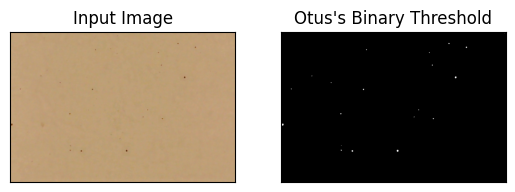

In [ ]:
# Change working directory
%cd ..
%cd 'Encoded Pictures'

# Obtain RGB values of the image
img = cv2.imread('2% Dispersant Additive Example.jpg')
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])

# Grayscale the Image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # very similar to cv2.imread('2% Hitec Example.jpg', 0)

# Threshold the Image
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Portray the resulting image
plt.subplot(121), plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(thresh, 'gray')
plt.title("Otus's Binary Threshold"), plt.xticks([]), plt.yticks([])

plt.show()               

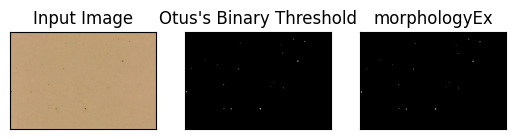

In [ ]:
# Noise removal using morphologyEx() --> we can switch between opening and closing to see which one is better
kernel = np.ones((2, 2), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)

# Display the images again
plt.subplot(131), plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(thresh, 'gray')
plt.title("Otus's Binary Threshold"), plt.xticks([]), plt.yticks([])

plt.subplot(133), plt.imshow(closing, 'gray')
plt.title("morphologyEx"), plt.xticks([]), plt.yticks([])

plt.show()

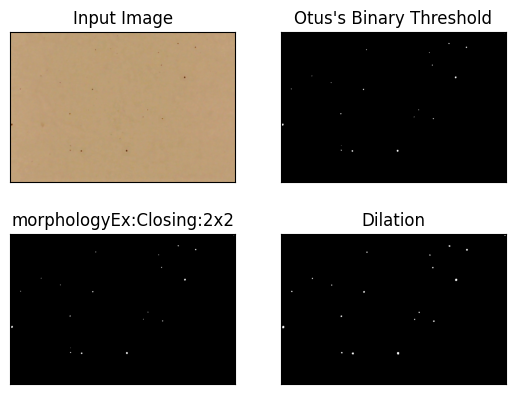

In [ ]:
# Dilate our image so that thresholding is much easier to visualize (for ourselves and the computer)
# Dilate with respect to the background
bg = cv2.dilate(opening, kernel, iterations = 3)

# Show the images again
plt.subplot(221), plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(222), plt.imshow(thresh, 'gray')
plt.title("Otus's Binary Threshold"), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(closing, 'gray')
plt.title("morphologyEx:Closing:2x2"), plt.xticks([]), plt.yticks([])

plt.subplot(224), plt.imshow(bg, 'gray')
plt.title("Dilation"), plt.xticks([]), plt.yticks([])

plt.show()

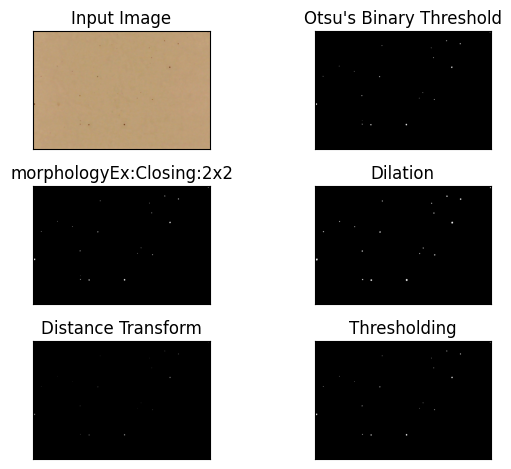

In [ ]:
# Apply distance thresholding to increase accuracy for overall threshold
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)

# Overall Threshold
ret, fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

# Display the images again
plt.subplot(321), plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(322), plt.imshow(thresh, 'gray')
plt.title("Otsu's Binary Threshold"), plt.xticks([]), plt.yticks([])

plt.subplot(323), plt.imshow(closing, 'gray')
plt.title("morphologyEx:Closing:2x2"), plt.xticks([]), plt.yticks([])

plt.subplot(324), plt.imshow(bg, 'gray')
plt.title("Dilation"), plt.xticks([]), plt.yticks([])

plt.subplot(325), plt.imshow(dist_transform, 'gray')
plt.title("Distance Transform"), plt.xticks([]), plt.yticks([])

plt.subplot(326), plt.imshow(fg, 'gray')
plt.title("Thresholding"), plt.xticks([]), plt.yticks([])

plt.tight_layout()

# Save the current 6 images into Google Drive
# plt.savefig('images.png',
#             bbox_inches='tight',
#             pad_inches=0,
#             format='png',
#             dpi=300)

plt.show()

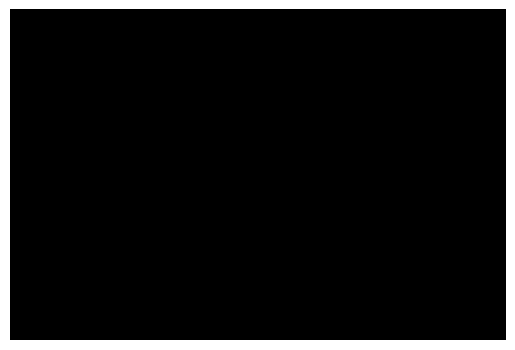

In [ ]:
# Let's create a Black Background

import cv2

# Define the dimensions of the image
width = 1359
height = 906

# Create a black image with the desired dimensions
img = np.zeros((height, width, 3), dtype=np.uint8)
img.fill(0)

# Display the image
plt.axis('off')
plt.imshow(img)

# Save black background.
cv2.imwrite("black-background.jpg", img)

plt.show()

[Errno 2] No such file or directory: 'Thresholded Images'
/content/gdrive/Shareddrives/Krauss Tribology Research/Fall 2022 - Spring 2023/Pictures


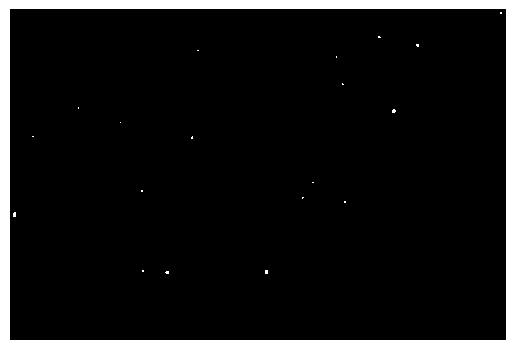

In [ ]:
import matplotlib.image as mpimg

# remove the axes and white border
plt.axis('off')
fig = plt.imshow(fg, cmap="gray", interpolation='nearest')

fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# Set directory to Thresholded Images folder
%cd 'Thresholded Images'

# save the image
plt.savefig('threshold_image.png',
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)

plt.show()

In [ ]:
# Image Resizing to account for particles along the edges of the image

from PIL import Image

image = Image.open('threshold_image.png')
print(f"Original size : {image.size}") # ~1359x906

img_resized = image.resize((1200, 800))

# Set directory to the Resized Images folder
%cd ..
%cd 'Resized Images'

img_resized.save('resized_image.png')

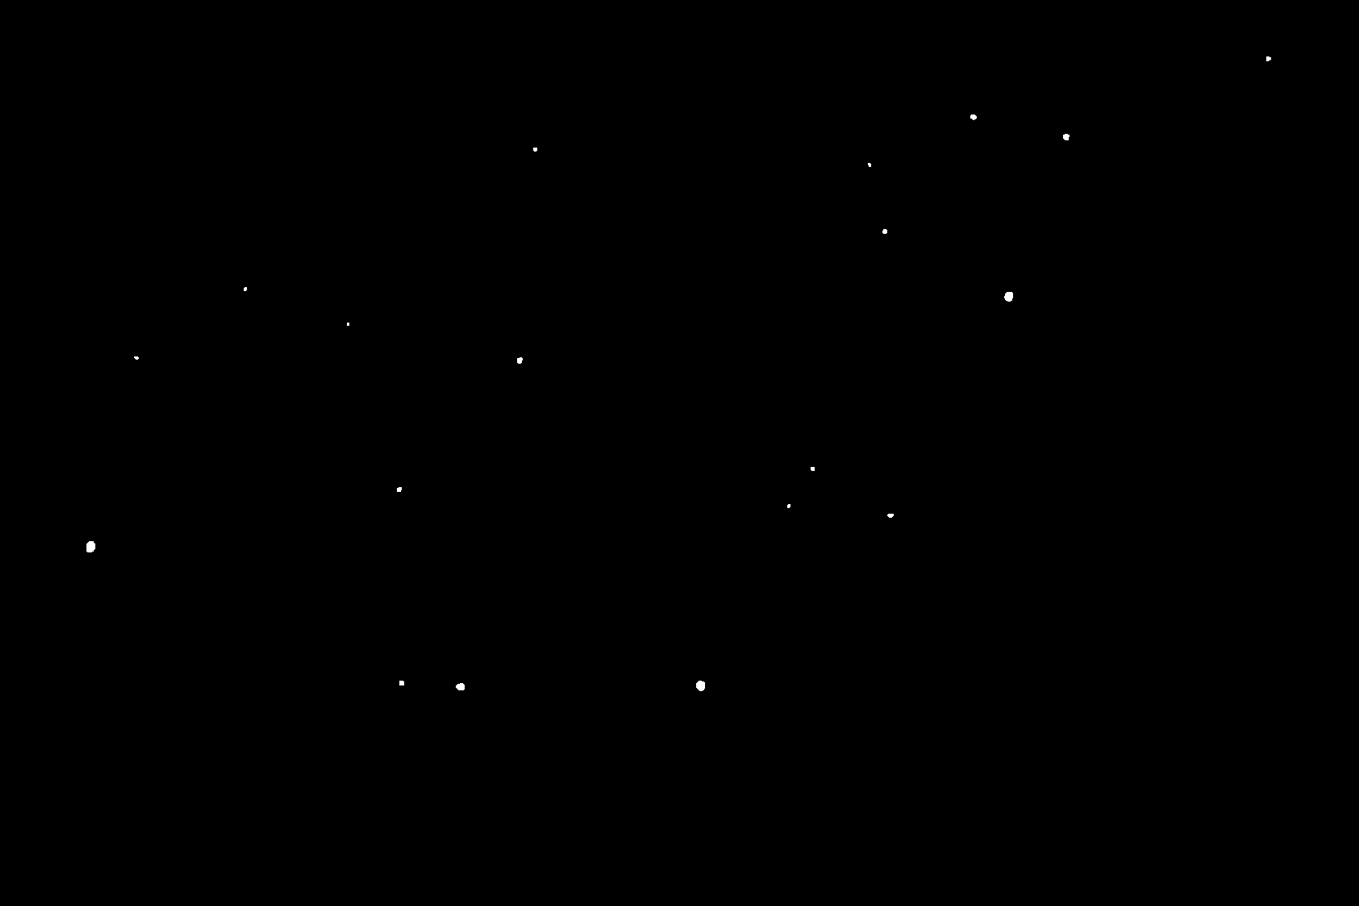

In [ ]:
# Overlay the Shrunken Image on the Black Background

from PIL import Image

# Set directory to the Resized Images folder
%cd ..

# Opening the primary image (used in background)
img1 = Image.open(r"black-background.jpg")
  
# Opening the secondary image (overlay image)
%cd 'Resized Images'
img2 = Image.open(r"resized_image.png")

# Pasting img2 image on top of img1 
# starting at coordinates (0, 0)
img1.paste(img2, (80, 50), mask = img2)
  
# Displaying the image
img1.show()

# Set directory to the Resized Images folder
%cd ..
%cd 'Resulting Images'

# Save the image
img1.save("resulting_image.jpeg", "JPEG")

# Reset directory
%cd ..                      # Change this to wherever we first started (or wherever the next particle image is)